<br>

# Introdução

In [1]:
#!pip3 install open-geodata --upgrade

In [12]:
import os
import sys
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from folium import plugins
from datetime import date

In [13]:
from open_geodata import geo, functions, lyr, converts
from open_geodata import folium_plus

In [14]:
mod_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(mod_path)
from sisagua.ibge import *

In [15]:
from paths import *

<br>

Lista quais os Municípios que exportei dados.

In [16]:
os.listdir(output_path)

['3501608', '3505203', '3526902', '3548906']

In [17]:
# Parameters
#cod_ibge = '3505203' # Bariri
cod_ibge = '3501608' # Americana
#cod_ibge = '3548906' # São Carlos
#cod_ibge = '3526902' # Limeira

In [18]:
# Adjust Code
#cod_ibge_ajustado = adjust_id_ibge(cod_ibge)

# Estado
#estado_d = find_states(cod_ibge)
#estado = estado_d['sigla']

# Path name
#city_path = '{}_{}'.format(estado, cod_ibge_ajustado)
#city_path

<br>

Confere se o município selecionado tem dados exportados

In [19]:
cod_ibge in os.listdir(output_path)

True

<br>

Cria Diretórios de output de Mapas

In [20]:
geo_path = os.path.join(output_path, str(cod_ibge), 'analysis_geo')
os.makedirs(geo_path, exist_ok=True)

<br>

# Layers

<br>

## ETAs

A concepção inicial era avaliar as coordenadas de latitude e longitude das ETAs, porém observei que no Siságua não existem essas informações

In [21]:
# Read Table
df = pd.read_excel(
    os.path.join(output_path, str(cod_ibge), 'dados brutos', 'cadastro', 'cadastro_tratamento_de_agua.xlsx')
)

# Filtra os Últimos
if date.today().year in set(df['Ano De Referência']):
    df = df.loc[df['Ano De Referência'] == date.today().year]
    df.reset_index(drop=True, inplace=True)
    print(df.info())
else:
    print('Erro')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 58 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Região Geográfica                                    157 non-null    object 
 1   Regional De Saúde                                    157 non-null    object 
 2   Município                                            157 non-null    object 
 3   Tipo Da Instituição                                  157 non-null    object 
 4   Sigla Da Instituição                                 0 non-null      float64
 5   Nome Da Instituição                                  157 non-null    object 
 6   Cnpj Da Instituição                                  157 non-null    float64
 7   Nome Do Escritório Regional/Local                    0 non-null      float64
 8   Cnpj Do Escritório Regional/Local                    0 non-null      f

In [22]:
# Seleciona SAA
df = df.loc[df['Tipo Da Forma De Abastecimento'].str.startswith('SAA')]

# Seleciona SAC
#df.loc[df['Código Forma De Abastecimento'].str.startswith('SAC')]

# Results
df.head()

,Região Geográfica,Regional De Saúde,Município,Tipo Da Instituição,Sigla Da Instituição,Nome Da Instituição,Cnpj Da Instituição,Nome Do Escritório Regional/Local,Cnpj Do Escritório Regional/Local,Tipo Da Forma De Abastecimento,...,Fonte,Cisterna,Canalização,Outro Tipo De Suprimento,Responsável Técnico,Formação Profissional Do Responsável Técnico,Número Do Conselho De Classe Do Responsável Técnico,Anotação De Responsabilidade Técnica (Art),Uf,Código Ibge
0,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,NaN,DEPARTAMENTO DE AGUA E ESGOTO,4.675569e+13,NaN,NaN,SAA,...,NaN,NaN,NaN,NaN,LEANDRO TRESOLDI,Engenharia Civil,0601147970,NaN,SP,350160


<br>

## Captação

In [23]:
# Read Table
df = pd.read_excel(
    os.path.join(output_path, str(cod_ibge), 'dados brutos', 'cadastro', 'cadastro_pontos_captacao.xlsx')
)

# Filtra os Últimos
if date.today().year in set(df['Ano De Referência']):
    df = df.loc[df['Ano De Referência'] == date.today().year]
    df.reset_index(drop=True, inplace=True)
    print(df.info())
else:
    print('Erro')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Região Geográfica                           160 non-null    object 
 1   Regional De Saúde                           160 non-null    object 
 2   Município                                   160 non-null    object 
 3   Tipo Da Instituição                         160 non-null    object 
 4   Sigla Da Instituição                        0 non-null      float64
 5   Nome Da Instiuição                          160 non-null    object 
 6   Nome Do Escritório Regional/Local           0 non-null      float64
 7   Cnpj Do Escritório Regional/Local           0 non-null      float64
 8   Tipo Da Forma De Abastecimento              160 non-null    object 
 9   Código Forma De Abastecimento               160 non-null    object 
 10  Nome Da Forma 

<AxesSubplot:>

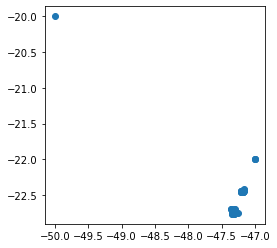

In [24]:
# Adjusta os dtypes
df['Longitude'] = pd.to_numeric(df['Longitude'].str.replace(',', '.'), errors='coerce')
df['Latitude'] = pd.to_numeric(df['Latitude'].str.replace(',', '.'), errors='coerce')

# Convert
gdf = converts.df2geojson2(df, lat='Latitude', long='Longitude', epsg=4326)
gdf.plot()

In [25]:
# Save
gdf.to_file(
    os.path.join(geo_path, 'cadastro_pontos_captacao.geojson'),
    driver='GeoJSON'
)

# Results
gdf.head(2)

/home/michel/Documents/conda/envs/pablocarreira-py39/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,Região Geográfica,Regional De Saúde,Município,Tipo Da Instituição,Sigla Da Instituição,Nome Da Instiuição,Nome Do Escritório Regional/Local,Cnpj Do Escritório Regional/Local,Tipo Da Forma De Abastecimento,Código Forma De Abastecimento,...,Tipo De Captação,Categoria Do Manancial Superficial,Nome Do Manancial Superficial,Categoria Do Ponto De Captação Subterrâneo,Nome Do Ponto De Captação Subterrâneo,Outorga,Vazão,Uf,Código Ibge,geometry
0,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,NaN,DEPARTAMENTO DE AGUA E ESGOTO,NaN,NaN,SAA,S350160000001,...,SUPERFICIAL,rio,RIO PIRACICABA,NaN,NaN,S,953.00,SP,350160,POINT (-50.00000 -20.00000)
1,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,NaN,ANTONIO SERGIO LEITE DE CAMARGO CIA LTDA EPP,NaN,NaN,SAC,C350160000001,...,SUBTERRANEO,NaN,NaN,POÇO ARTESIANO,POCO 001 DAEE 248-0199,S,2.31,SP,350160,POINT (-47.17922 -22.42433)


In [26]:
#gdf.columns
#set(gdf['Tipo De Captação'])
#set(gdf['Tipo Da Forma De Abastecimento'])

In [27]:
def add_lyr_captacao_saa(geojson_path):
    # Input
    gdf = gpd.read_file(os.path.join(geojson_path, 'cadastro_pontos_captacao.geojson'))
    gdf = gdf.loc[gdf['Tipo Da Forma De Abastecimento'] == 'SAA']
    
    n_not_empty = len(gdf)
    n_empty = len(gdf.loc[gdf['geometry'] == None])
    
    gdf = gdf.loc[gdf['geometry'] != None]
    gdf = gdf.to_crs(epsg=4326)
    print(
        """O layer "Captação SAA" tem {} registros com coordenadas e {} registros sem coordenadas""".format(
            n_not_empty,
            n_empty
        )
    )
    
    # Popup
    gdf['popup'] = gdf.apply(popup_html_captacoes, axis=1)
    
    # Style
    colors = {
        'SUBTERRANEO': 'pink',
        'SUPERFICIAL': 'blue',
    }    
    
    # Group
    feature_group = folium.FeatureGroup('Captações SAA')
    
    # Loop
    for index, row in gdf.iterrows():
        #
        lyr = folium.Marker(
            location=[row['geometry'].y, row['geometry'].x],
            popup=folium.Popup(
                folium.Html(row['popup'], script=True),
                min_width=350,
                max_width=450,
                parse_html=True,
            ),
            tooltip=row['Nome Da Forma De Abastecimento'],
            icon=folium.Icon(color=colors[row['Tipo De Captação']])
        )
        
        feature_group.add_child(lyr)
    return feature_group

In [28]:
gdf = gpd.read_file(os.path.join(geo_path, 'cadastro_pontos_captacao.geojson'))
gdf = gdf.loc[gdf['Tipo Da Forma De Abastecimento'] == 'SAC']
# gdf['geometry'] = gdf['geometry'].replace('None', np.nan)
gdf = gdf.loc[gdf['geometry'] == None]
# gdf = gdf.to_crs(epsg=4326)
# if len(gdf)>0:
#     print('s')

gdf

,Região Geográfica,Regional De Saúde,Município,Tipo Da Instituição,Sigla Da Instituição,Nome Da Instiuição,Nome Do Escritório Regional/Local,Cnpj Do Escritório Regional/Local,Tipo Da Forma De Abastecimento,Código Forma De Abastecimento,...,Tipo De Captação,Categoria Do Manancial Superficial,Nome Do Manancial Superficial,Categoria Do Ponto De Captação Subterrâneo,Nome Do Ponto De Captação Subterrâneo,Outorga,Vazão,Uf,Código Ibge,geometry
2,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,None,DEPARTAMENTO DE AGUA E ESGOTO,None,None,SAC,C350160000301,...,SUBTERRANEO,None,None,POÇO ARTESIANO,Ponto 1,S,0.00,SP,350160,None
3,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,None,EQUIPE BOMBAS POCOS ARTESIANOS EIRELI,None,None,SAC,C350160000192,...,SUBTERRANEO,None,None,POÇO ARTESIANO,Ponto 1,S,0.00,SP,350160,None
4,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,None,FLORENCA PALACE HOTEL LTDA,None,None,SAC,C350160000054,...,SUBTERRANEO,None,None,POÇO ARTESIANO,POÇO 01,S,1.39,SP,350160,None
5,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,None,EQUIPE BOMBAS POCOS ARTESIANOS EIRELI,None,None,SAC,C350160000182,...,SUBTERRANEO,None,None,POÇO ARTESIANO,Ponto 1,S,0.00,SP,350160,None
6,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,None,EQUIPE BOMBAS POCOS ARTESIANOS EIRELI,None,None,SAC,C350160000143,...,SUBTERRANEO,None,None,POÇO ARTESIANO,Ponto 1,S,0.00,SP,350160,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,None,EQUIPE BOMBAS POCOS ARTESIANOS EIRELI,None,None,SAC,C350160000178,...,SUBTERRANEO,None,None,POÇO ARTESIANO,Ponto 1,S,0.00,SP,350160,None
155,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,None,CONDOMINIO RESIDENCIAL ITAPEMA,None,None,SAC,C350160000318,...,SUBTERRANEO,None,None,POÇO ARTESIANO,Ponto 1,S,0.00,SP,350160,None
156,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,None,DIA BRASIL SOCIEDADE LIMITADA,None,None,SAC,C350160000087,...,SUBTERRANEO,None,None,POÇO ARTESIANO,Ponto 1,N,0.00,SP,350160,None
157,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,Local,None,DEPARTAMENTO DE AGUA E ESGOTO,None,None,SAC,C350160000308,...,SUBTERRANEO,None,None,POÇO ARTESIANO,Ponto 1,S,0.00,SP,350160,None


In [29]:
def add_lyr_captacao_sac(geojson_path):
    # Input
    gdf = gpd.read_file(os.path.join(geojson_path, 'cadastro_pontos_captacao.geojson'))
    gdf = gdf.loc[gdf['Tipo Da Forma De Abastecimento'] == 'SAC']
    
    n_not_empty = len(gdf)
    n_empty = len(gdf.loc[gdf['geometry'] == None])

    gdf = gdf.loc[gdf['geometry'] != None]
    gdf = gdf.to_crs(epsg=4326)
    print(
        """O layer "Captação SAC" tem {} registros com coordenadas e {} registros sem coordenadas""".format(
            n_not_empty,
            n_empty
        )
    )

    # Popup
    gdf['popup'] = gdf.apply(popup_html_captacoes, axis=1)

    # Style
    colors = {
        'SUBTERRANEO': 'pink',
        'SUPERFICIAL': 'blue',
    }    

    # Group
    feature_group = folium.FeatureGroup(
        'Captações SAC',
        show=False
    )

    # Loop
    for index, row in gdf.iterrows():
        #
        lyr = folium.Marker(
            location=[row['geometry'].y, row['geometry'].x],
            popup=folium.Popup(
                folium.Html(row['popup'], script=True),
                min_width=350,
                max_width=450,
                parse_html=True,
            ),
            tooltip=row['Nome Da Forma De Abastecimento'],
            icon=folium.Icon(color=colors[row['Tipo De Captação']])
        )

        feature_group.add_child(lyr)
    return feature_group

In [30]:
def popup_html_captacoes(row):
    # Data
    nome = row['Nome Da Instiuição']
    tipo = row['Tipo De Captação']
    outorga = row['Outorga']
    tipo_forma = row['Tipo Da Forma De Abastecimento']
    nome_forma = row['Nome Da Forma De Abastecimento']
	
    # Infos
    popup = """
    <div>
    <h5>{}</h5>
    <br>Responsável: <b>{}</b>
    <br>Tipo da Forma de Abastecimento: <b>{}</b>
    <br>Nome da Forma de Abastecimento: <b>{}</b>
    <br>Tem Ouutorga?: <b>{}</b>
    </div>
    """.format(tipo_forma, nome, tipo, nome_forma, outorga)
    return popup

<br>

## Município

In [31]:
# List geodataframes
geo.get_dataset_names()

# Load geodataframe
gdf_sp = geo.load_dataset('sp_250k_wgs84')

/home/michel/Documents/conda/envs/pablocarreira-py39/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


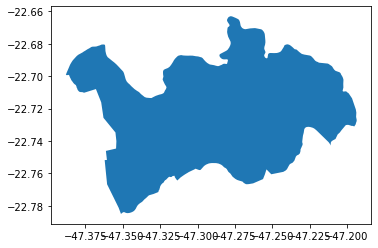

In [32]:
gdf_sp_mun = gdf_sp.loc[gdf_sp['id_municipio'] == int(cod_ibge)]
gdf_sp_mun.plot()
gdf_sp_mun.to_file(
    os.path.join(geo_path, 'limite_municipio.geojson'),
    driver='GeoJSON'
)

In [33]:
def add_lyr_municipio(geojson_path):
    # Input
    gdf = gpd.read_file(os.path.join(geojson_path, 'limite_municipio.geojson'))
    gdf = gdf.to_crs(epsg=4326)
    
    # Popup
    #gdf['popup'] = gdf.apply(popup_html_est_aut_empresas, axis=1)

    # Layer
    return folium.GeoJson(
        gdf,
        name='Limite Municipal',
        smooth_factor=1.0,
        style_function=lambda x: {
            'fillColor': '#f7f7f7',
            'color': '#f7f7f7',
            'weight': 3,
            'fillOpacity': 0.1,
        },
        highlight_function=lambda x: {
            'weight': 5,
            'fillOpacity': 0.1,
        },
        # popup=folium.GeoJsonPopup(
        #     ['popup'],
        #     parse_html=False,
        #     max_width='400',
        #     show=False,
        #     labels=False,
        #     sticky=True,            
        # ),
        marker=folium.Marker(
            icon=folium.Icon(
                color='lightgray',
                icon_color='#FFFF00',
                #icon='leaf',
            ),
        ),
        # tooltip=folium.GeoJsonTooltip(
        #     fields=['municipio_nome'],
        #     aliases=['Município'],
        #     sticky=True,
        #     opacity=0.9,
        #     direction='right',
        # ),
        embed=False,
        zoom_on_click=False,
        control=True,
        show=False,
    )

<br>

## Municípios Vizinhos

/home/michel/Documents/conda/envs/pablocarreira-py39/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

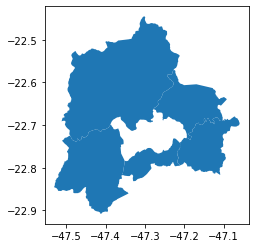

In [34]:
gdf_sp_viz = functions.share_boundary(gdf_sp, gdf_sp_mun)
gdf_sp_viz.to_file(
    os.path.join(geo_path, 'limite_municipios_vizinhos.geojson'),
    driver='GeoJSON'
)
gdf_sp_viz.plot()

In [35]:
def add_lyr_municipios_vizinhos(geojson_path):
    # Input
    gdf = gpd.read_file(os.path.join(geojson_path, 'limite_municipios_vizinhos.geojson'))
    gdf = gdf.to_crs(epsg=4326)    
    
    # Popup
    #gdf['popup'] = gdf.apply(popup_html_est_aut_empresas, axis=1)

    # Layer
    return folium.GeoJson(
        gdf,
        name='Limite Municipíos Vizinhos',
        smooth_factor=1.0,
        style_function=lambda x: {
            'fillColor': '#b8b8b8',
            'color': '#b8b8b8',
            'weight': 1,
            'fillOpacity': 0.6,
        },
        highlight_function=lambda x: {
            'weight': 3,
            'fillOpacity': 0.2,
        },
        # popup=folium.GeoJsonPopup(
        #     ['popup'],
        #     parse_html=False,
        #     max_width='400',
        #     show=False,
        #     labels=False,
        #     sticky=True,            
        # ),
        marker=folium.Marker(
            icon=folium.Icon(
                color='lightgray',
                icon_color='#FFFF00',
                #icon='leaf',
            ),
        ),
        tooltip=folium.GeoJsonTooltip(
            fields=['municipio_nome'],
            aliases=['Município'],
            sticky=True,
            opacity=0.9,
            direction='right',
        ),
        embed=False,
        zoom_on_click=False,
        control=True,
        show=True,
    )

<br>

# Map

In [36]:
def get_map(input_geojson):
    # Input
    gdf = gpd.read_file(input_geojson)
    gdf = gdf.to_crs(epsg=4326)
    sw = gdf.bounds[['miny', 'minx']].min().values.tolist()
    ne = gdf.bounds[['maxy', 'maxx']].max().values.tolist()
    bounds = [sw, ne]
    
    # Zoom
    min_zoom = 8
    max_zoom = 21
    padding = 1
    
    # Create Map
    m = folium.Map(
        min_zoom=min_zoom,
        max_zoom=max_zoom,
        max_bounds=True,
        min_lat=bounds[0][0]*((100+padding)/100),
        min_lon=bounds[0][1]*((100+padding)/100),
        max_lat=bounds[1][0]*((100-padding)/100),
        max_lon=bounds[1][1]*((100-padding)/100),
        tiles=None,
        # zoom_delta=0.1,
        # zoom_start=10,
    )
    
    # Add Layers
    m.add_child(lyr.base.google_hybrid(min_zoom, max_zoom))
    m.add_child(lyr.base.google_satellite(min_zoom, max_zoom))
    m.add_child(lyr.base.google_terrain(min_zoom, max_zoom))    
    m.add_child(lyr.base.google_streets(min_zoom, max_zoom))    

    # Monitoramento
    try: m.add_child(add_lyr_captacao_saa(geo_path))
    except: pass
    try: m.add_child(add_lyr_captacao_sac(geo_path))
    except: pass
    m.add_child(add_lyr_municipio(geo_path))
    m.add_child(add_lyr_municipios_vizinhos(geo_path))    

    # Plugins
    m.fit_bounds(bounds)
    plugins.Fullscreen(
        position='topleft',
        title='Clique para Maximizar',
        title_cancel='Mininizar',
    ).add_to(m)
    folium.LayerControl(
        position='topright',
        collapsed=False,
    ).add_to(m)
    return m

In [37]:
# Create Maps
m = get_map(os.path.join(geo_path, 'limite_municipios_vizinhos.geojson'))

# Add Legend
colors = {
    'SUBTERRANEO': 'pink',
    'SUPERFICIAL': 'blue',
}
m = folium_plus.adds.add_categorical_legend(m, title='Captações', color_by_label=colors)

# Save
m.save(os.path.join(geo_path, 'map_captacao.html'))

# Results
m

O layer "Captação SAA" tem 1 registros com coordenadas e 0 registros sem coordenadas
O layer "Captação SAC" tem 159 registros com coordenadas e 112 registros sem coordenadas
